# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [7]:
import numpy as np
import corner

In [11]:
from relaxed.analysis import get_mah
from relaxed.models import training_suite, prepare_datasets

# Data

In [25]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [26]:
# catalog
cat = mah_data['cat']

ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']

In [27]:
# prepare catalog with all a_m
am_names = [f'am_{ii}' for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])

In [54]:
params = ('cvir',  'cvir_klypin', 't/|u|', 'x0', 'q','b_to_a', 'c_to_a',  'spin', 'spin_bullock', )
info = {
    'all': {'x': am_names, 'y': params, },
}
datasets, cat_train, cat_test = prepare_datasets(cat, info)

# Train

In [55]:
# joint models
opcam_dict = {
'cvir': {'mbin': 0.5, 'order': -1}, 
'cvir_klypin': {'mbin': 0.397, 'order': -1}, 
't/|u|': {'mbin': 0.67, 'order': +1}, 
'x0': {'mbin': 0.738, 'order': +1}, 
'q': {'mbin': 0.67, 'order': -1},
'b_to_a': {'mbin': 0.673, 'order': -1}, 
'c_to_a': {'mbin': 0.644, 'order': -1}, 
'spin': {'mbin': 0.54, 'order': +1},
'spin_bullock': {'mbin': 0.54, 'order': +1},
 }

data ={
    'multicam': {
        'xy': datasets['all']['train'], 'n_features': 100, 'n_targets': len(params), 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'optcam': {
        'xy': datasets['all']['train'], 'n_features': 100, 'n_targets': len(params), 
        'model': 'mixed_cam', 'kwargs':{'mass_bins':mass_bins, 
                                        'opt_mbins':[opcam_dict[param]['mbin'] for param in params], 
                                        'cam_orders':[opcam_dict[param]['order'] for param in params]
                                        },
    }
}
joint_models = training_suite(data)


# Triangle plot 

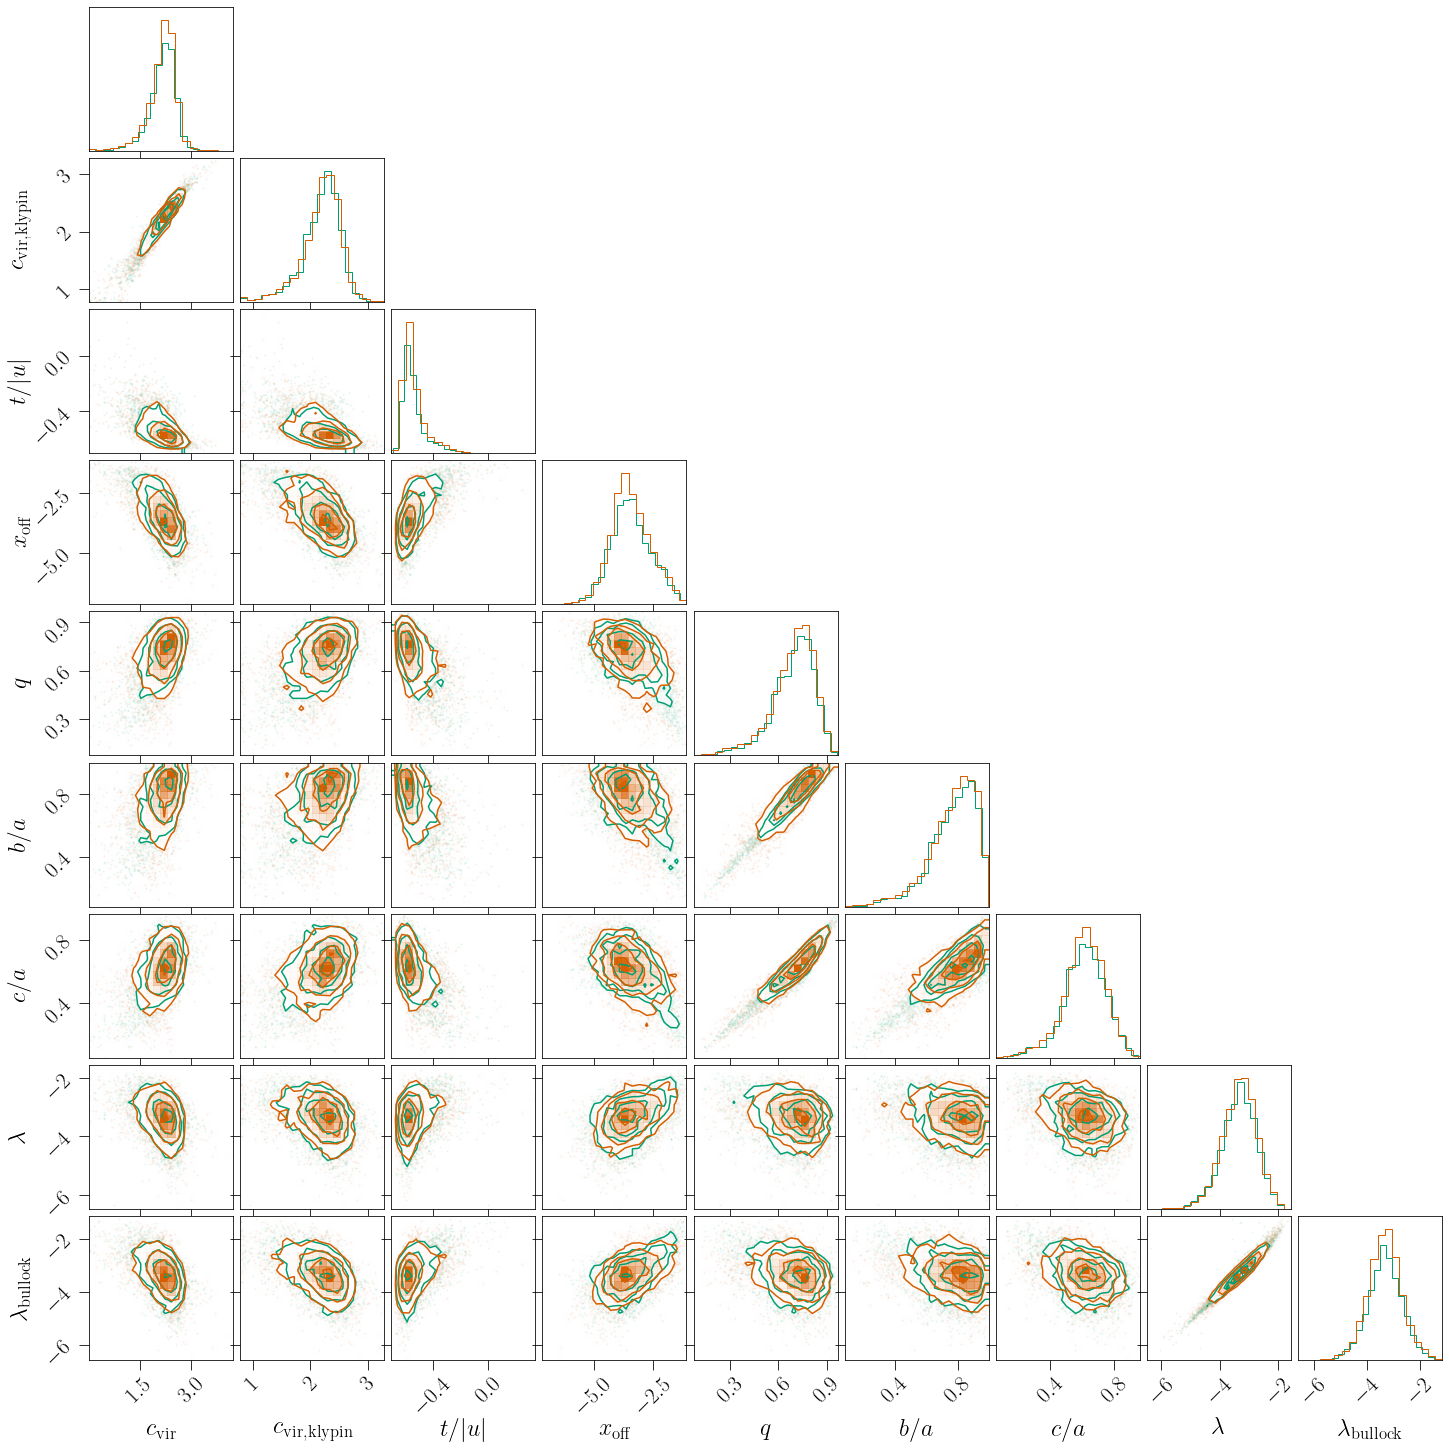

In [61]:
# multi-gaussian approach should do the best.
am_test = datasets['all']['test'][0]
model = joint_models['multicam']
y_true = np.hstack([cat_test[param].reshape(-1, 1) for param in params]).reshape(-1, len(params))
y_samples = model.sample(am_test, 1).reshape(-1, len(params))

# ellipticty parameters look better not logged
y1 = np.log(y_true)
y1[:, 4:7] = np.exp(y1[:, 4:7])

y2 = np.log(y_samples)
y2[:, 4:7] = np.exp(y2[:, 4:7])

labels = [latex_params[param] for param in params]
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples

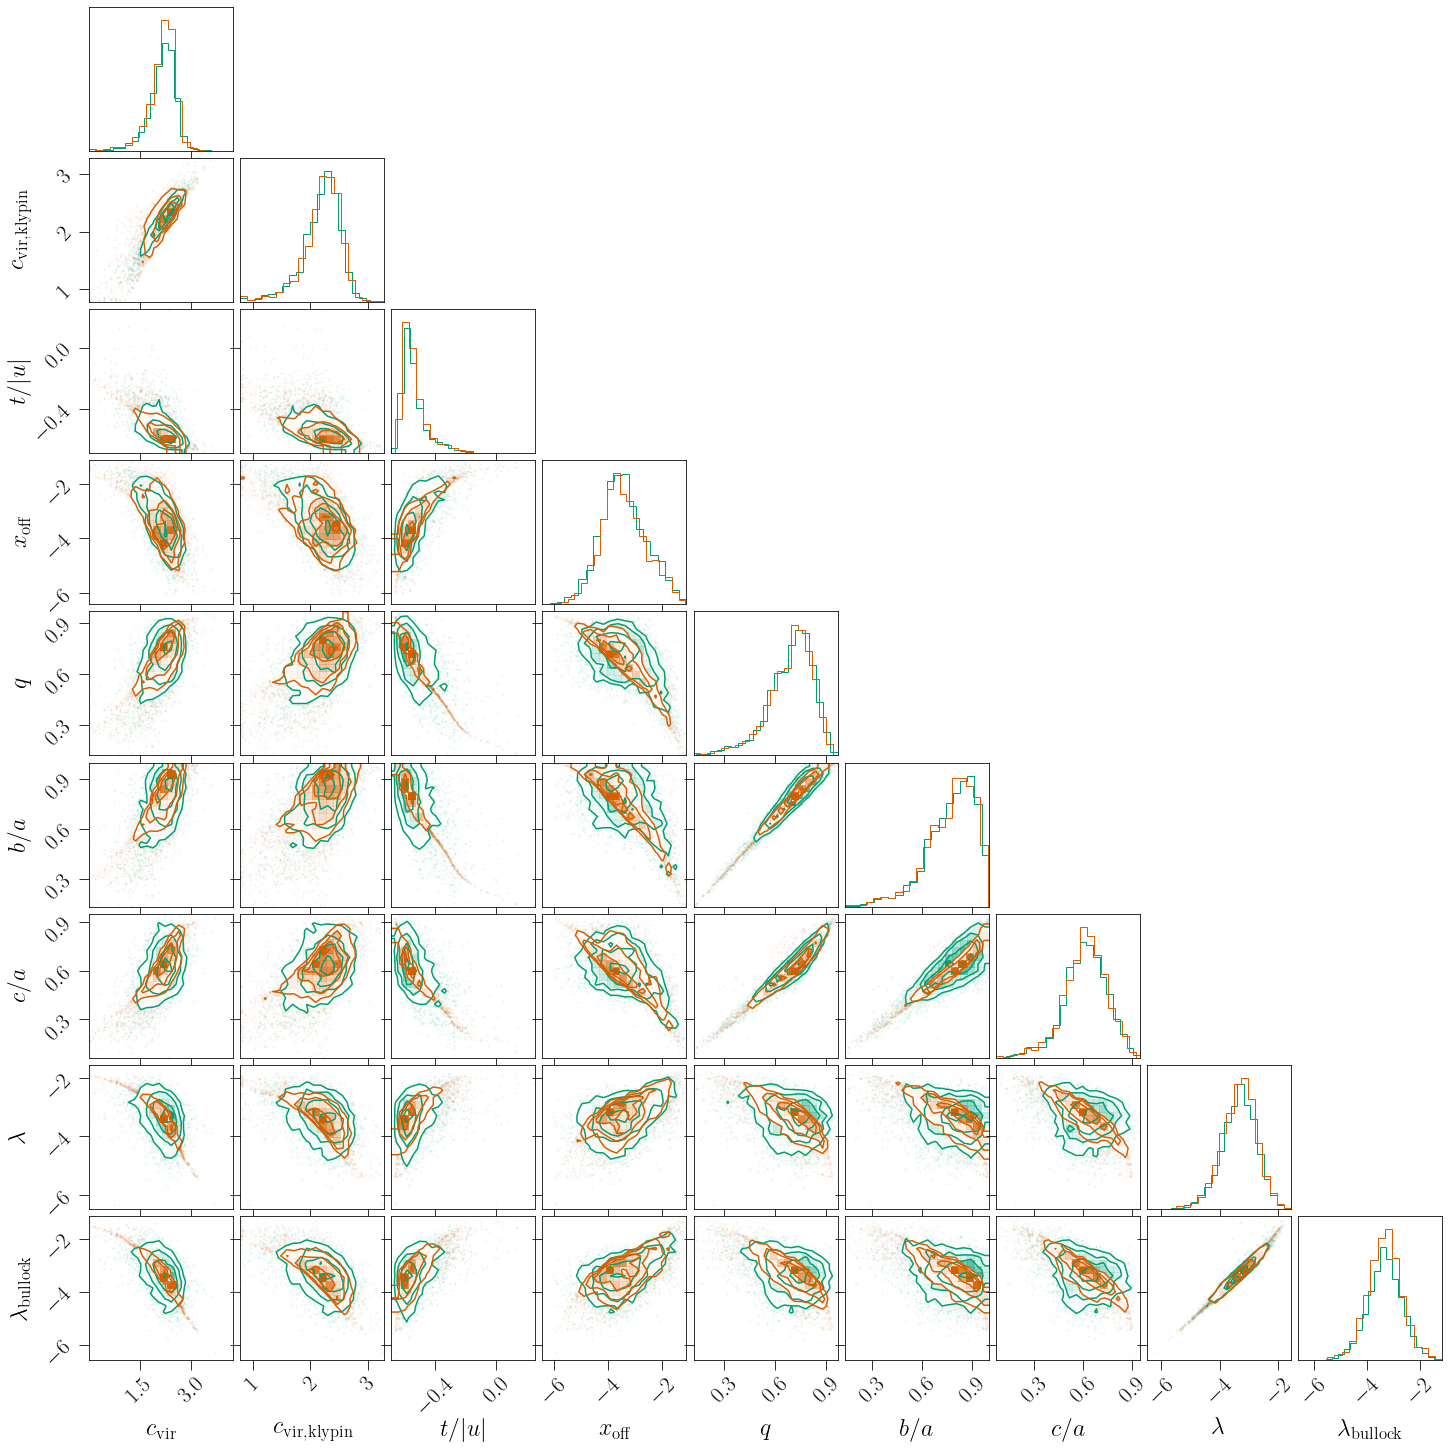

In [63]:
# CAM approach should do the best.
am_test = datasets['all']['test'][0]
model = joint_models['optcam']
y_true = np.hstack([cat_test[param].reshape(-1, 1) for param in params]).reshape(-1, len(params))
y_samples = model.predict(am_test).reshape(-1, len(params))

# ellipticty parameters look better not logged
y1 = np.log(y_true)
y1[:, 4:7] = np.exp(y1[:, 4:7])

y2 = np.log(y_samples)
y2[:, 4:7] = np.exp(y2[:, 4:7])

labels = [latex_params[param] for param in params]
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples

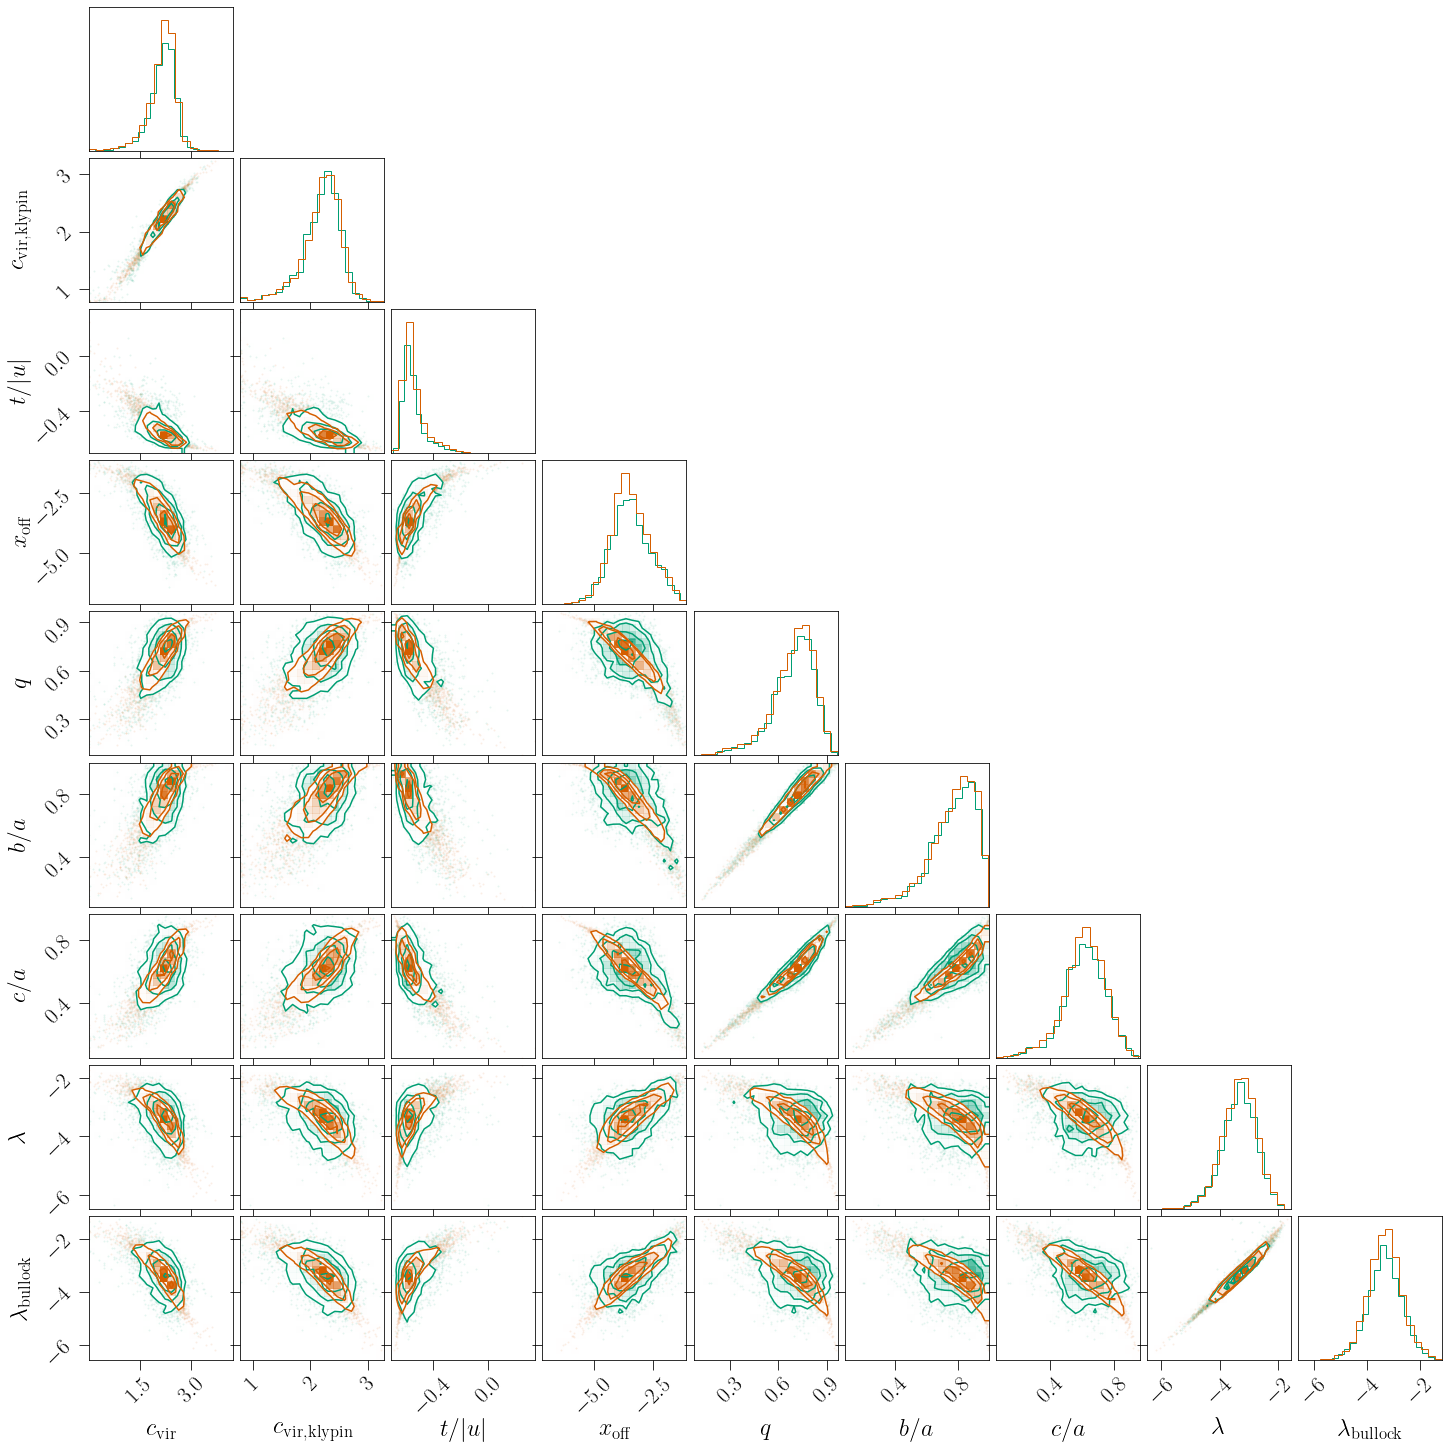

In [66]:
am_test = datasets['all']['test'][0]
model = joint_models['multicam']
y_true = np.hstack([cat_test[param].reshape(-1, 1) for param in params]).reshape(-1, len(params))
y_samples = model.predict(am_test).reshape(-1, len(params))

# ellipticty parameters look better not logged
y1 = np.log(y_true)
y1[:, 4:7] = np.exp(y1[:, 4:7])

y2 = np.log(y_samples)
y2[:, 4:7] = np.exp(y2[:, 4:7])

labels = [latex_params[param] for param in params]
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples